# 人工晶体度数计算中的参数估计与优化

发现了一篇[Determination of Personalized IOL-Constants for the Haigis Formula under Consideration of Measurement Precision](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0158988)

里面讲的是使用加权最小二乘法来进行Haigis公式的参数优化。我打算使用他的数据，而利用贝叶斯方法做同样的事情。练会这一招以后，其他IOL计算公式的参数优化也是一样的。

# 获得数据

必须得说，临床医学的公开数据比起做计算机的，真是少多了。除了哪些有机器学习强力推动的图像数据集，要找一个开放的数据集还真是困难，虽然理论上，不过就是白内障术前测量和术后复查的IOL数据，好像一抓一大把。但术后IOL稳定至少要3个月，国内的白内障病人3个月后还能追踪到也不是件容易的事情。

不过，现在有些杂志要求给出Data Availability，
所以加上“Data Availability”这个关键词以后能够找到一些带有原始数据的文章。
有些文章假么假事地说are available from the corresponding author on reasonable request.但有些文章很实诚，直接就在Supporting Information里给出excel文件。
用google找似乎发现的成功率更高一些。

我就是使用这个方法找到了这篇讲 Haigis公式参数优化的文章[Determination of Personalized IOL-Constants for the Haigis Formula under Consideration of Measurement Precision](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0158988)

在Supporting Information里面，可以下载到原始的数据。好心的作者已经整理成excel文件了。

* [数据1](https://doi.org/10.1371/journal.pone.0158988.s001) 植入的是博士伦 EyeCeeOne NS-60YG 人工晶体，一共75只眼。
* [数据2](https://doi.org/10.1371/journal.pone.0158988.s002) 植入的是Alcon  Acrysof SN60WF 人工晶体，有121只眼

我已经把这两个数据都下载下来，放在/data/haigis_data目录中，分别是"S1 File.XLSX", "S1 File.XLSX"

# 读取数据

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np
np.random.seed(42)
 
# Matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)

import seaborn as sns

import os

In [2]:
# 这里使用了一个小技巧，因为我并不知道您使用的计算机是什么系统的，所以路径使用了os.path.join进行合并。
# pandas可以直接读取excel文件，读取成pandas数据库
s1=pd.read_excel(os.path.join("data","haigis_data","S1 File.XLSX"))
# s2=pd.read_excel(os.path.join("data","haigis_data","S2 File.XLSX"))

In [3]:
s1.head()

,Eye,AL,D1 [mm],°,D2 [mm],°.1,ACD,IOL power,target refraction,Unnamed: 9,refraction - 6 months postOP,Unnamed: 11,Unnamed: 12,VA,SE,Unnamed: 15
0,OD,24.97,7.15,171.0,7.04,81.0,3.57,16.5,-2.50,NaN,-4.00,0.50,68,0.8,-3.750,EyeCee One NS-60YG
1,OS,21.62,7.80,95.0,7.59,5.0,2.49,29.0,-0.99,NaN,-0.75,1.50,164,0.6,0.000,EyeCee One NS-60YG
2,OS,26.53,8.06,10.0,7.89,100.0,3.94,17.5,-2.73,NaN,-3.25,0.75,120,1.0,-2.875,EyeCee One NS-60YG
3,OS,22.03,7.51,169.0,7.44,79.0,2.74,25.5,-0.48,NaN,-0.50,0.25,64,1.0,-0.375,EyeCee One NS-60YG
4,OD,23.05,7.99,76.0,7.88,166.0,2.94,25.0,-0.69,NaN,-0.25,0.75,169,0.4,0.125,EyeCee One NS-60YG


# 清洗数据

读取进来的数据是需要清洗的。excel中有一些是空白的数据，pandas在读取时会以NaN （Not a Number）标记。有些列是不需要的，或者是空列。

清洗的时候，先删除掉空列，使用[drop命令](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop.html), 然后再使用dropna()把含有NaN的行都删掉。注意命令的顺序，如果先删除含有NaN的行，那么就没有剩下的数据了。

Haigis公式并不针对散光，所以只需要保留其中的眼轴长AL，角膜曲率半径D1，角膜曲率半径D2，前房深度ACD，植入的IOL度数IOL power，和术后6个月的屈光度refraction - 6 months postOP，其他的数据列是不需要的。

另外，s1表格中，单位都是以毫米记录的，而在计算过程中通常是以米作为标准单位。所以需要稍微转换一下

In [4]:
df=pd.DataFrame()
df['AL']=s1['AL']/1000
df['D1']=s1['D1 [mm]']/1000
df['D2']=s1['D2 [mm]']/1000
df['ACD']=s1['ACD']/1000
df['IOL power']=s1['IOL power']
df['postOP refraction']=s1['refraction - 6 months postOP']
df=df.dropna()

简单浏览一下数据的概貌, 丢弃NaN数据以后，保留了69个有效的数据

In [5]:
df.describe()

,AL,D1,D2,ACD,IOL power,postOP refraction
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,0.023565,0.007726,0.007579,0.003092,21.797101,-0.815942
std,0.001379,0.000303,0.000305,0.000439,3.499284,1.055291
min,0.020340,0.007080,0.006510,0.002160,13.000000,-4.000000
25%,0.022740,0.007510,0.007390,0.002770,20.000000,-1.250000
50%,0.023260,0.007740,0.007570,0.003130,22.500000,-0.500000
75%,0.024230,0.007970,0.007810,0.003410,24.000000,-0.250000
max,0.027980,0.008420,0.008270,0.003940,30.000000,1.750000


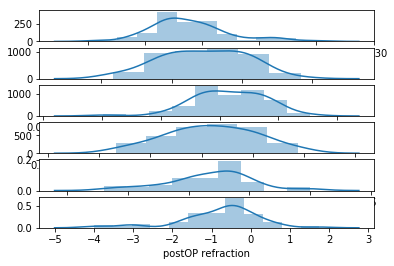

In [6]:
f, axes = plt.subplots(len(df.columns), 1)

for col,ax in zip(df.columns,axes):
    sns.distplot(df[col],ax=ax)

# Haigis公式

这里从文献的引言部分讲起, 请参考[原文](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0158988#sec001)

Haigis公式
$$
D=\frac{n}{L-d}-\frac{n}{\frac{R_{x}}{K_{m}+\frac{R_{x}}{1-R_{x} \cdot 0.012 m}}-d} \tag{1}
$$

是基于一个简化的角膜薄透镜模型，该模型仅使用角膜前表面的角膜曲率值来计算有效角膜屈光力 Km，使用 nc = 1.332的平均角膜屈光指数进行计算。 

* Rx是计划屈光度。
* 术后光学前房深度 d 不一定与术后生理性前房深度相对应。
* 房水的折射率n = 1.336，
* ACD是有晶体眼时的前房深度，
* L是眼轴长度

**预测**的光学前房深度d，由下面公式给出：
$$
d=a_{0}+A C D \cdot a_{1}+L \cdot a_{2} \tag{2}
$$

其中Haigis公式中的a0,a1,a2是IOL型号特异性的，每个厂家每种型号不一定相同。

术后**实际**光学前房深度可通过求解方程 1 的 d，推导得出, 将方程 1 中计划的屈光度 Rx 替换为术后实际的屈光度 F。 
$$
z=K_{m}+\frac{F}{1-F \cdot 0.012 \mathrm{m}} \tag{3}
$$

得到化简的方程1

$$
d=\frac{1}{2}\left(L+\frac{n}{z}\right)-\sqrt{\frac{1}{4}\left(L+\frac{n}{z}\right)^{2}-\left(L \frac{n}{z}-\frac{n^{2}}{D z}+n \frac{L}{D}\right)} \tag{4}
$$

方程4得到的d，应该和方程2得到的d之间误差尽量小，所谓优化参数，就是找到合适的$a_{0},a_{1},a_{2}$, 使得方程4-方程2的平方和最小

$$
\chi_{\mathrm{olsq}}^{2}=\sum_{i}\left(a_{0}+A C D_{i} \cdot a_{1}+L_{i} \cdot a_{2}-d_{i}\right)^{2}
$$



# 线性回归

其实上面就是个线性回归的问题，也就是求解 Y = K X + b


In [7]:
def Km(D1,D2,nc):
    K1=(nc-1)/D1
    K2=(nc-1)/D2
    return (K1+K2)/2

def z(Km,F):
    return Km+F/(1-F*0.012)
    
def real_d(L,n,z,D):
    d_part_1=1/2*(L+n/z)
    d_part_2=1/4*(L+n/z)**2
    d_part_3=L*n/z-n**2/(D*z)+n*L/D
    d = d_part_1-np.sqrt(d_part_2-d_part_3)
    return d

In [8]:
nc=1.332
K_=Km(df['D1'],df['D2'], nc)
F=df['postOP refraction']
z_=z(K_,F)
L=df['AL']
ACD = df['ACD']
n=1.336
D=df['IOL power']
df['real_d']=real_d(L,n,z_,D)

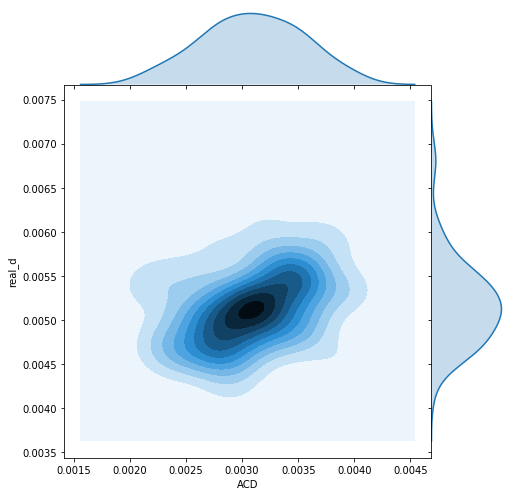

In [9]:
sns.jointplot(df['ACD'], df['real_d'], kind="kde", height=7, space=0)

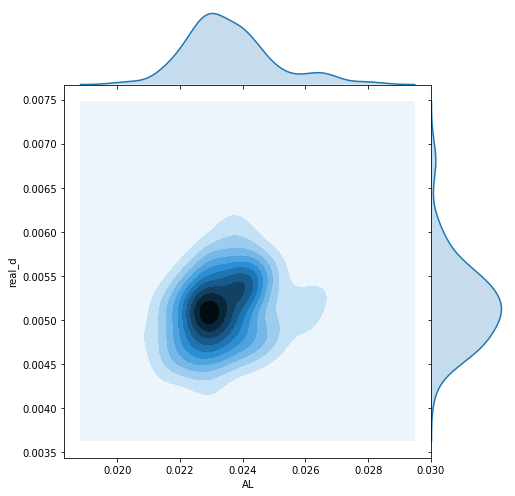

In [10]:
sns.jointplot(df['AL'], df['real_d'], kind="kde", height=7, space=0)

In [11]:
%matplotlib inline

from pymc3 import  *

import numpy as np
import matplotlib.pyplot as plt

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [13]:
df.head()

,AL,D1,D2,ACD,IOL power,postOP refraction,real_d
0,0.02497,0.00715,0.00704,0.00357,16.5,-4.00,0.005568
1,0.02162,0.00780,0.00759,0.00249,29.0,-0.75,0.004660
2,0.02653,0.00806,0.00789,0.00394,17.5,-3.25,0.005314
3,0.02203,0.00751,0.00744,0.00274,25.5,-0.50,0.004844
4,0.02305,0.00799,0.00788,0.00294,25.0,-0.25,0.005106


In [12]:
x=np.asarray([ACD.values, L.values]).T
y=df['real_d'].values
data = {'x': x, 'y': y}

In [37]:
df.ACD.std()

0.0004388668758260951

In [39]:
with Model() as model:
    priors = {
          'real_d': Normal.dist(mu=df.real_d.mean(), sd=df.real_d.std()),
          'ACD': Normal.dist(mu=df.ACD.mean(), sd=9.4e-5),
          'AL': Normal.dist(mu=df.AL.mean(), sd= 10e-5)
    }
    GLM.from_formula('real_d ~ ACD+AL', df, priors=priors)
    trace = sample(2000, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, AL, ACD, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [01:21<00:00, 61.17draws/s]
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9987245213342595, but should be close to 0.8. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [15]:
# with Model() as model:
#     lm = glm.LinearComponent.from_formula('real_d ~ ACD+AL', df)
#     sigma = Uniform('sigma', 0, 10)
#     y_obs = Normal('y_obs', mu=lm.y_est, sd=sigma, observed=df.real_d)
#     trace = sample(2000, cores=2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, AL, ACD, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:43<00:00, 75.81draws/s]
The acceptance probability does not match the target. It is 0.9178898715861374, but should be close to 0.8. Try to increase the number of tuning steps.


In [40]:
traceplot(trace)

/Users/goldengrape/anaconda3/envs/blog/lib/python3.6/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c20d7b240>,
      dtype=object)

ValueError: Image size of 269568x482 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 864x576 with 8 Axes>

In [41]:
print("a0={}, 95% CI ({},{})".format(
    np.mean(trace['Intercept']),
    np.mean(trace['Intercept'])-2*np.std(trace['Intercept']),
    np.mean(trace['Intercept'])+2*np.std(trace['Intercept'])))

print("a1={}, 95% CI ({},{})".format(
    np.mean(trace['ACD']),
    np.mean(trace['ACD'])-2*np.std(trace['ACD']),
    np.mean(trace['ACD'])+2*np.std(trace['ACD'])))

print("a2={}, 95% CI ({},{})".format(
    np.mean(trace['AL']),
    np.mean(trace['AL'])-2*np.std(trace['AL']),
    np.mean(trace['AL'])+2*np.std(trace['AL'])))


# print('a1=',np.mean(trace['ACD']), 'std=',np.std(trace['ACD']))
# print('a2=',np.mean(trace['AL']), 'std=',np.std(trace['AL']))


a0=0.004494105917341967, 95% CI (0.004248810605595004,0.00473940122908893)
a1=0.0031200890964775264, 95% CI (0.0029762217878275305,0.0032639564051275224)
a2=0.023505824526418053, 95% CI (0.02331571680032767,0.023695932252508437)
